**Chess engine training**

In this notebook I will train a simple ML model to be able to evaluate a chess position, returning the evaluation of the position. A positive value indicates an advantage for white, a negative value indicates an advantage for black. eg. +1 means that white has an advantage equivalent to 1 extra pawn of material. In reality, this number not only takes into account the material imbalance, but also the positional imbalance. The more positive this number, the bigger the advantage for white; the more negative, the bigger the advantage for black.

In order to train the model, we need a dataset consisting of chess positions annotated with their respective evaluation. Lichess provides monthly datasets of annotated games, so I downloaded the file corresponding to February 2017, containing about 10M games. Of these, about 6% of them are annotated with the evaluation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_id = '1VDvPP6MFgZI0PfAATIV8lRE922WSNYcm'
url = 'https://drive.google.com/uc?id={}'.format(file_id)

In [ ]:
!pzstd -d /content/drive/MyDrive/lichess_db_standard_rated_2017-02.pgn.zst .

pzstd: /content/drive/MyDrive/lichess_db_standard_rated_2017-02.pgn.zst: Output file exists.
pzstd: .: Output file is a directory -- ignored.


We will be using the python chess library to parse the PGN of the positions.

In [ ]:
!pip install chess
import chess.pgn
import re
import csv


The PGN contains a lot of info about each games, like opponents, moves, etc. We are only interested in extracting the FEN and the evaluation for each position of each game. The FEN is a string containing 6 fields, separated by a space.

An example of FEN:
*rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1*

The first field (the long string) represents the current placement of the pieces on the board. The second field indicates the active color (w=white, b=black). The third field indicates the castling availability, for each color and on each side. The fourth field indicates if there is a en passant target square. The fifth field indicates the number of halfmoves since the last capture or pawn advance, while the last field indicates the number of full moves.

Now we will parse the data and save the positions of 30,000 games into a csv, for easier reading afterwards.

In [ ]:
fn = '/content/drive/MyDrive/lichess_db_standard_rated_2017-02.pgn'
f = open('database2.csv', 'w')
writer = csv.writer(f, delimiter=',')
header = ['FEN','color','castling','en_passant','halfmove','fullmove','eval']
writer.writerow(header)
c = 0

with open(fn, encoding='utf-8') as h:
    while True:
        i = 0
        game = chess.pgn.read_game(h)
        #if game is None:
        #    break
        moves_str = str(game.mainline())
        if 'eval' in moves_str:
          moves = re.findall(r'{ \[%eval #*(-*[0-9.]*)\] }',moves_str)
          fens = []
          while game.next():
              game=game.next()
              fens.append(str(game.board().fen()))
          if(len(fens)==len(moves)):
            for i in range(0,len(fens)):
              row = []
              fields = f"{fens[i]} {moves[i]}".split(' ')
              writer.writerow(fields)
          c+=1
          if not c % 500:
            f.flush()
            print(f"game saved: {c}")
          if c==30000:
            break

f.close()

Let's create a dataframe containing all the records.

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("database2.csv")
df.head()

,FEN,color,castling,en_passant,halfmove,fullmove,eval
0,rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR,b,KQkq,-,0,1,0.05
1,rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBNR,w,KQkq,-,0,2,0.08
2,rnbqkbnr/pppp1ppp/8/4p3/8/1P6/PBPPPPPP/RN1QKBNR,b,KQkq,-,1,2,-0.04
3,r1bqkbnr/pppp1ppp/2n5/4p3/8/1P6/PBPPPPPP/RN1QKBNR,w,KQkq,-,2,3,-0.01
4,r1bqkbnr/pppp1ppp/2n5/4p3/8/1P2P3/PBPP1PPP/RN1...,b,KQkq,-,0,3,0.05


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384488 entries, 0 to 1384487
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   FEN         1384488 non-null  object 
 1   color       1384488 non-null  object 
 2   castling    1384488 non-null  object 
 3   en_passant  1384488 non-null  object 
 4   halfmove    1384488 non-null  int64  
 5   fullmove    1384488 non-null  int64  
 6   eval        1384488 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 73.9+ MB


The dataset contains about 1.4M positions and has 7 columns (the 6 extracted from the FEN + the evaluation, which is the target variable). Before training a model, we need to manipulate the data a bit.

First, we only keep records with eval between -20 and +20, to eliminate extreme positions and make the training easier.

In [ ]:
df = df[abs(df['eval'])<20]

Then we change the color column into a number - 0 if white has the move, 1 if black has the move.

In [ ]:
df["color"] = np.where(df["color"] == "w", 0, 1)

We also split the 'castling' column into 4 different columns, indicating respectively if white has kingside castling availability, queenside castling availability, and if black has kingside and queenside castling availability.

In [ ]:
df['K_castling'] = df['castling'].apply(lambda x: 1 if 'K' in x else 0)
df['Q_castling'] = df['castling'].apply(lambda x: 1 if 'Q' in x else 0)
df['k_castling'] = df['castling'].apply(lambda x: 1 if 'k' in x else 0)
df['q_castling'] = df['castling'].apply(lambda x: 1 if 'q' in x else 0)
df = df.drop('castling', axis=1)

For the 'en passant' column, there are 16 possible target squares (on the 3rd and 6th row). However, we can just keep the information about the file, because the information about the row (3rd or 6th) is already included in the "color" column, so it is redundant. Therefore, we just need 8 numbers to codify the 8 columns, + 0 to codify the situation where there are no en passant target square (which is represented by a '-' in the original FEN). Therefore, we can convert the 'en_passant' column to numerical with the following function:

In [ ]:
df['en_passant'].unique()

array(['-', 'c3', 'd6', 'c6', 'g3', 'e6', 'f3', 'b3', 'f6', 'b6', 'd3',
       'e3', 'a3', 'h6', 'a6', 'h3', 'g6'], dtype=object)

In [ ]:
en_passant_map = {
    'a':1,
    'b':2,
    'c':3,
    'd':4,
    'e':5,
    'f':6,
    'g':7,
    'h':8,
    '-':0
  }

def en_passant(x):
    for key,value in en_passant_map.items():
      if key in x:
        return(value)

df['en_passant'] = df['en_passant'].apply(en_passant)

Now we need to manipulate the first field (the long string that represents the position) in order to convert it to numerical. First we replace the numbers with a series of zero (e.g. 4 means there are 4 empty squares, so we put 4 zeros) and we remove the '/' separating the rows. Hence we obtain:

In [ ]:
def convert_fen(fen):
  new_fen = ""
  for x in fen:
    if x.isdigit():
      for i in range(0,int(x)):
        new_fen+='0'
    elif x=='/':
      pass
    else:
      new_fen+=x
  return(new_fen)

df['FEN'] = df['FEN'].apply(convert_fen)
df

,FEN,color,en_passant,halfmove,fullmove,eval,K_castling,Q_castling,k_castling,q_castling
0,rnbqkbnrpppppppp0000000000000000000000000P0000...,1,0,0,1,0.05,1,1,1,1
1,rnbqkbnrpppp0ppp000000000000p000000000000P0000...,0,0,0,2,0.08,1,1,1,1
2,rnbqkbnrpppp0ppp000000000000p000000000000P0000...,1,0,1,2,-0.04,1,1,1,1
3,r0bqkbnrpppp0ppp00n000000000p000000000000P0000...,0,0,2,3,-0.01,1,1,1,1
4,r0bqkbnrpppp0ppp00n000000000p000000000000P00P0...,1,0,0,3,0.05,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
1384483,r0k000000000n000p000p0000pp00pQ000P00000000000...,0,0,0,31,-6.55,0,0,0,0
1384484,r0k000000000n000p000p0000pp00pQ000P00000000000...,1,0,1,31,-13.51,0,0,0,0
1384485,r0k000000000n000p000p0000pp00pQ000P00000000000...,0,0,0,32,-12.64,0,0,0,0
1384486,r0k000000000n000p000p0000pp00pQ000P0000000K000...,1,0,1,32,-14.81,0,0,0,0


This way, the first field is now a string of 64 character, each representing one square of the board. We can therefore split this string into 64 fields:

In [ ]:
df = pd.concat([df['FEN'].apply(lambda x: pd.Series(list(x))),df],axis=1)

In [ ]:
df = df.drop('FEN', axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,63,color,en_passant,halfmove,fullmove,eval,K_castling,Q_castling,k_castling,q_castling
0,r,n,b,q,k,b,n,r,p,p,...,R,1,0,0,1,0.05,1,1,1,1
1,r,n,b,q,k,b,n,r,p,p,...,R,0,0,0,2,0.08,1,1,1,1
2,r,n,b,q,k,b,n,r,p,p,...,R,1,0,1,2,-0.04,1,1,1,1
3,r,0,b,q,k,b,n,r,p,p,...,R,0,0,2,3,-0.01,1,1,1,1
4,r,0,b,q,k,b,n,r,p,p,...,R,1,0,0,3,0.05,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384483,r,0,k,0,0,0,0,0,0,0,...,0,0,0,0,31,-6.55,0,0,0,0
1384484,r,0,k,0,0,0,0,0,0,0,...,0,1,0,1,31,-13.51,0,0,0,0
1384485,r,0,k,0,0,0,0,0,0,0,...,0,0,0,0,32,-12.64,0,0,0,0
1384486,r,0,k,0,0,0,0,0,0,0,...,0,1,0,1,32,-14.81,0,0,0,0


Now the first 64 fields contain information about the content of each square - if it is occupied by a piece or it is empty (0). We need to convert each letter representing a piece into a number, so we will use numbers from -6 to 6:

In [ ]:
def convert_square(x):
      match x:
        case 'K':
          return int(1)
        case 'Q':
          return int(2)
        case 'B':
          return int(3)
        case 'N':
          return int(4)
        case 'R':
          return int(5)
        case 'P':
          return int(6)
        case 'k':
          return int(-1)
        case 'q':
          return int(-2)
        case 'b':
          return int(-3)
        case 'n':
          return int(-4)
        case 'r':
          return int(-5)
        case 'p':
          return int(-6)
        case _:
          return x

df = df.applymap(convert_square)

Now we are ready to split the dataset into train and test.

In [ ]:
df = df.apply(pd.to_numeric)
X = df.drop('eval',axis=1)
y = df['eval']

We only keep 1% of the dataset as test, as we don't need more than that, and we use the other 99% for training.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=101)

For the ML model, I decided to use XGBoost, which should perform well with large number of records.

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=101)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=101, ...)

After training, we can use the model for predicting:

In [ ]:
predictions = xgb_model.predict(X_test)

In [ ]:
predictions

array([ 0.11025633, -1.8182809 ,  8.233402  , ..., -0.5881814 ,
       -0.06714562, -2.1729174 ], dtype=float32)

Let's re-manipulate the final dataset to have true evaluations and predictions side by side,

In [ ]:
df_out = pd.concat([X_test,y_test],axis=1)
df_out.dropna()

,0,1,2,3,4,5,6,7,8,9,...,63,color,en_passant,halfmove,fullmove,K_castling,Q_castling,k_castling,q_castling,eval
100405,-5,0,-3,-2,-1,-3,-4,-5,-6,-6,...,5,0,0,1,3,1,1,1,1,0.16
727579,-5,0,0,0,-1,0,0,-5,-6,-6,...,0,1,0,3,15,0,0,1,1,-0.69
395044,0,0,0,0,0,-5,0,-5,0,0,...,0,0,0,1,32,0,0,0,0,4.00
1248954,-5,0,0,0,-1,-3,0,-5,-6,-6,...,5,1,0,4,8,1,1,1,1,0.00
710057,0,0,0,0,0,0,0,0,0,0,...,0,1,0,15,58,0,0,0,0,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146104,-5,-3,-3,0,0,0,-1,0,-6,0,...,0,0,0,0,15,0,0,0,0,1.71
203160,-5,0,-3,-2,-1,-3,0,-5,-6,-6,...,5,1,0,1,7,0,0,1,1,0.29
1049819,0,0,-1,-5,0,0,-5,0,-6,-3,...,5,0,0,0,20,1,1,0,0,10.56
766629,-5,0,0,0,-5,0,0,0,0,0,...,0,1,0,0,28,0,0,0,0,-7.21


In [ ]:
predictions = xgb_model.predict(X_test)
df_out["preds"] = predictions


In [ ]:
df_out[20:50][['eval','preds']]

,eval,preds
127209,1.64,2.978710
1015664,-1.36,-1.159374
1335587,0.67,0.209741
1047015,5.95,1.196997
392212,-2.22,-0.250248
94362,0.54,0.322874
485193,-3.06,-0.870046
519351,0.93,0.481220
1211493,-0.01,-0.735213
717982,0.43,0.329967


At a first look it's hard to say whether the model is working or not. However, we can have a better idea by looking at the scatter plot of the predicted evaluation vs the true evaluation, and by looking at their correlation:

Text(0, 0.5, 'Predicted Y')

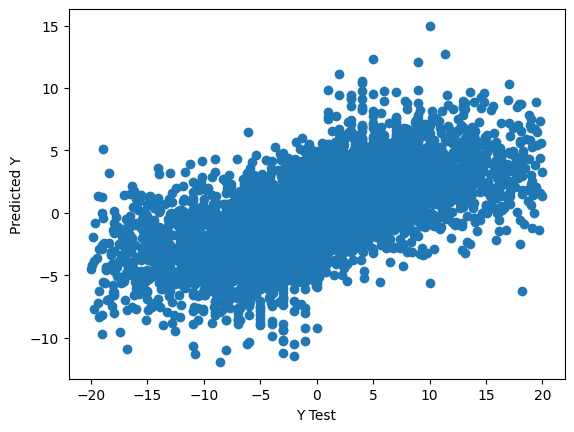

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df_out['eval'],df_out['preds'])
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [ ]:
df_out['preds'].corr(df_out['eval'])

0.6064877424299259

The correlation is about 0.60 - which means a modest correlation, which we can also observe from the scatter plot. Considering the small dataset used for training (1.3M positions are definitely not enough, considering how many chess positions are possible!), it is not that bad.

Now we can use the trained model to predict the evaluation from random games!

First we define a function to convert a FEN into the dataframe format that must be given in input into the model.

In [ ]:
def fen_to_df(fen):
  header = ['FEN','color','castling','en_passant','halfmove','fullmove']
  fen_list = fen.split()
  df_test = pd.DataFrame([fen_list],columns=header)
  df_test["color"] = np.where(df_test["color"] == "w", 0, 1)
  df_test['K_castling'] = df_test['castling'].apply(lambda x: 1 if 'K' in x else 0)
  df_test['Q_castling'] = df_test['castling'].apply(lambda x: 1 if 'Q' in x else 0)
  df_test['k_castling'] = df_test['castling'].apply(lambda x: 1 if 'k' in x else 0)
  df_test['q_castling'] = df_test['castling'].apply(lambda x: 1 if 'q' in x else 0)
  df_test = df_test.drop('castling', axis=1)
  df_test['en_passant'] = df_test['en_passant'].apply(en_passant)
  df_test['FEN'] = df_test['FEN'].apply(convert_fen)
  df_test = pd.concat([df_test['FEN'].apply(lambda x: pd.Series(list(x))),df_test],axis=1)
  df_test = df_test.drop('FEN', axis=1)
  df_test = df_test.applymap(convert_square)
  df_test = df_test.apply(pd.to_numeric)
  return(df_test)

**Evaluation**

Now I will use random positions from my own games and predict the evaluation with the trained model, comparing it with the true evaluation (using Stockfish).

1) White to move. Stockfish evaluation: +3.6

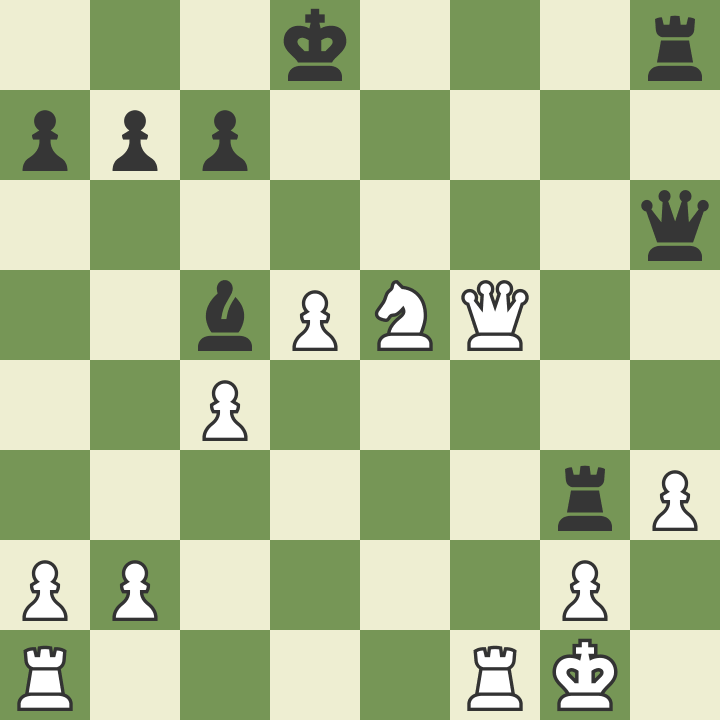

In [ ]:
fen = "3k3r/ppp5/7q/2bPNQ2/2P5/6rP/PP4P1/R4RK1 w - - 1 25"
df_test = fen_to_df(fen)
prediction = xgb_model.predict(df_test)
prediction

array([4.600449], dtype=float32)

**Model prediction: +4.6 vs +3.6 (true value)**. Not bad - the model correctly gives white a large advantage, although overestimating it a bit.

Now let's try with a more balanced position.

2) Black to move. Stockfish evaluation: +0.1

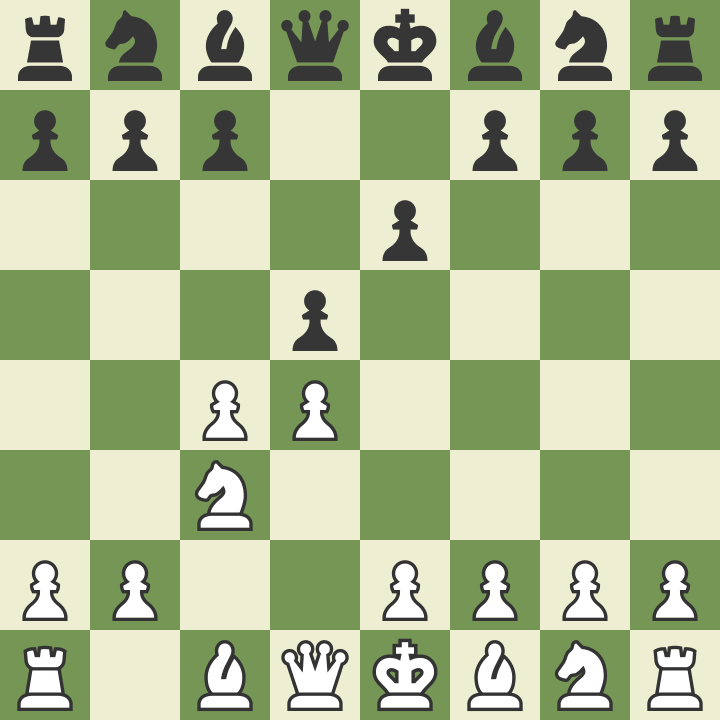

In [ ]:
fen = "rnbqkbnr/ppp2ppp/4p3/3p4/2PP4/2N5/PP2PPPP/R1BQKBNR b KQkq - 1 3"
df_test = fen_to_df(fen)
prediction = xgb_model.predict(df_test)
prediction


array([0.05614327], dtype=float32)

**Model prediction: +0.05 vs +0.1 (true value)**. Not bad! This was easier somehow, as this is a position that occurs often in the opening - so I expect the model to have seen this position already during the training phase.

Let's try then with another balanced position, but from the middlegame, which likely wasn't seen by our model during training.

3) White to move - Stockfish evaluation: +0.6

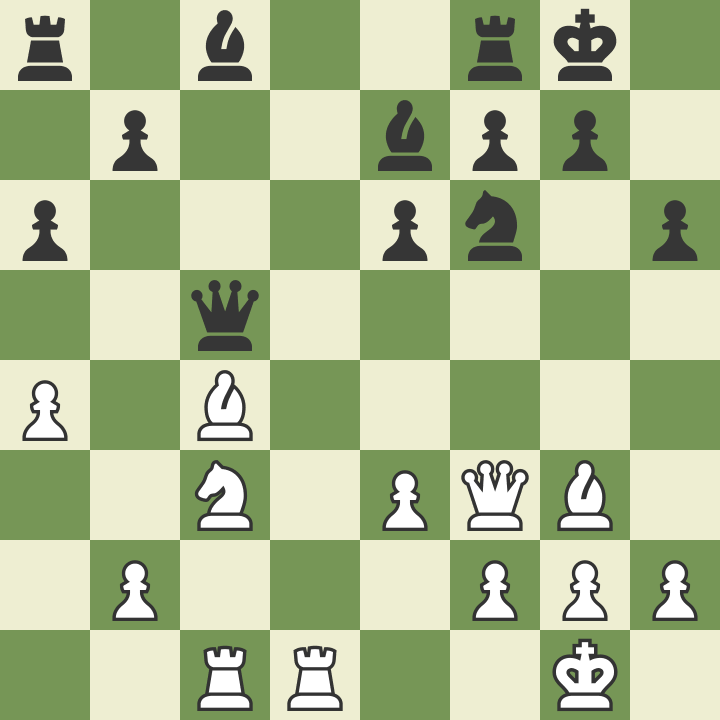

In [ ]:
fen = "r1b2rk1/1p2bpp1/p3pn1p/2q5/P1B5/2N1PQB1/1P3PPP/2RR2K1 w - - 8 18"
df_test = fen_to_df(fen)
prediction = xgb_model.predict(df_test)
prediction

array([0.8451736], dtype=float32)

**Model prediction: +0.8 vs +0.6 (true value)** - again not bad at all. The model correctly gives white a slight advantage.

Now let's try with a position with slight advantage for black.

4) Black to move - Stockfish evaluation: -0.5

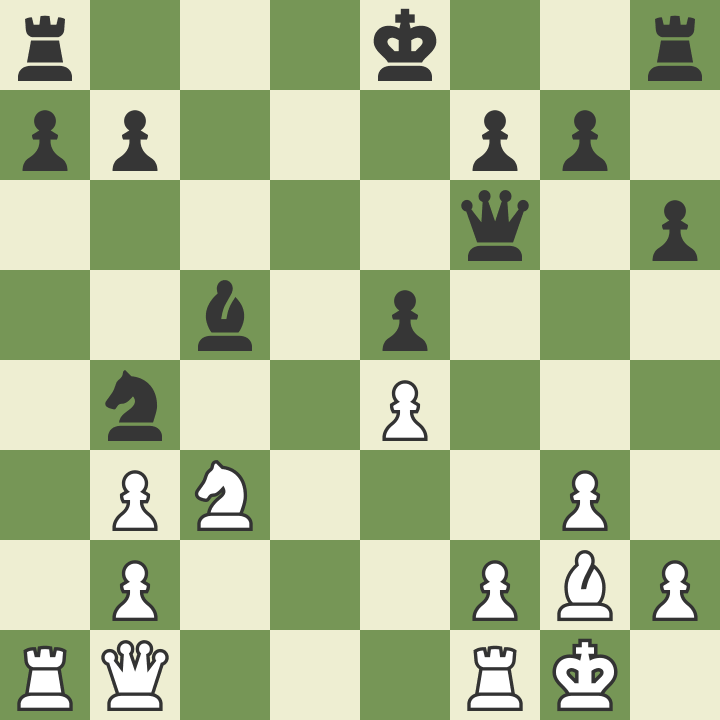

In [ ]:
fen = "r3k2r/pp3pp1/5q1p/2b1p3/1n2P3/1PN3P1/1P3PBP/RQ3RK1 b kq - 2 18"
df_test = fen_to_df(fen)
prediction = xgb_model.predict(df_test)
prediction

array([-0.28529596], dtype=float32)

**Model prediction: -0.3 vs -0.5 (true value)**. Again, the model is very close to the true evaluation.

Lastly, let's try with a position with large advantage for black:

5) White to move - Stockfish evaluation: -2.5

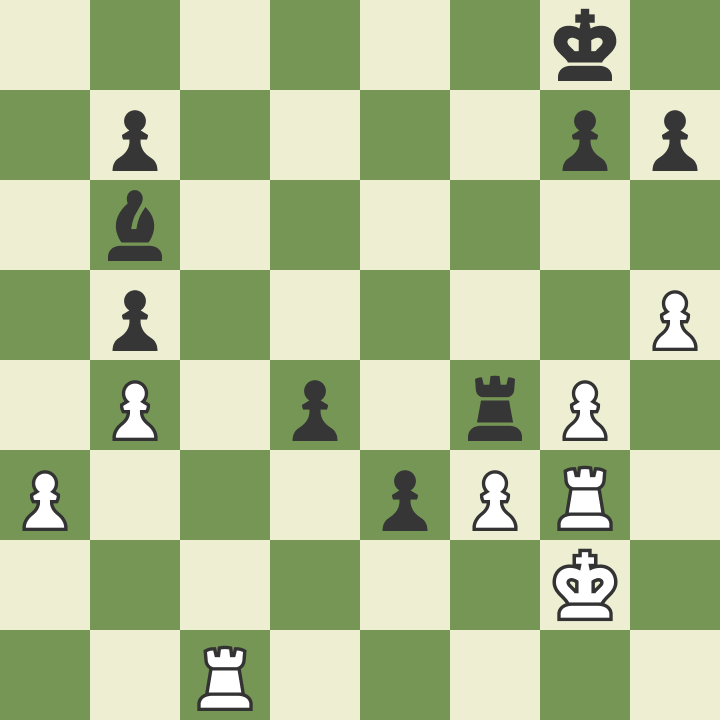

In [ ]:
fen = "6k1/1p4pp/1b6/1p5P/1P1p1rP1/P3pPR1/6K1/2R5 w - - 0 33"
df_test = fen_to_df(fen)
prediction = xgb_model.predict(df_test)
prediction

array([-5.155514], dtype=float32)

**Model prediction: -5.1 vs -2.5 (true value)** - here the model correctly gives black a significant advantage, although it overestimates it.

Finally, here is also a case where the model is completely off in its prediction:

6) White to move - Stockfish evaluation: +0.8

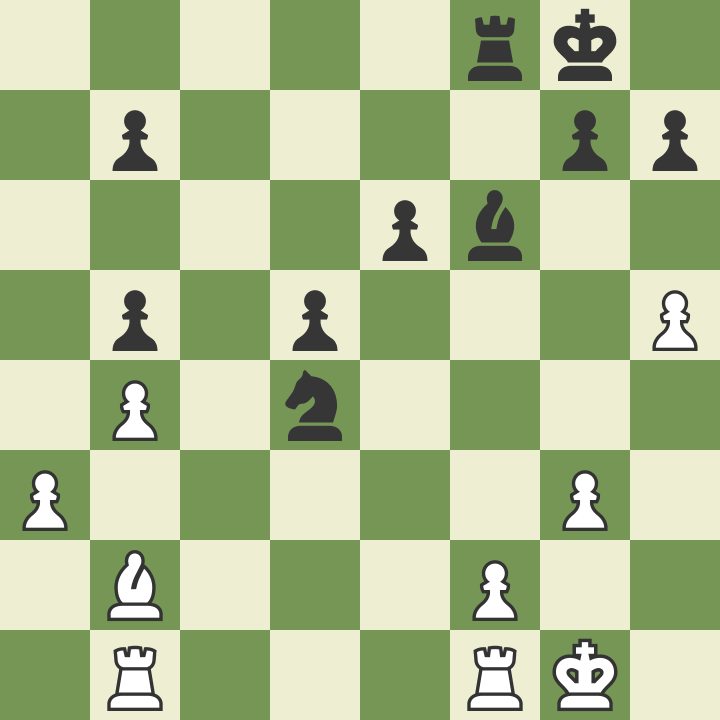

In [ ]:
fen = "5rk1/1p4pp/4pb2/1p1p3P/1P1n4/P5P1/1B3P2/1R3RK1 w - - 0 25"
df_test = fen_to_df(fen)
prediction = xgb_model.predict(df_test)
prediction

array([-3.020389], dtype=float32)

**Model prediction: -3.0 vs +0.8 (true value)** - here the model is completely off, since it gives black a big advantage, while in reality it's white that has a slight advantage.

**Conclusions:**

The trained model is very simplisting and has many limitations. First of all, the training dataset is not very large, since it includes 30,000 games only. Moreover, the model may not predict the evaluation accurately whenever there are tactics hidden in the position. A more complex model (neural network) would be more adequate for training a chess engine. Still, the results given by this very simple model are not too bad - the model seems to correctly predict at least which color has an advantage in the majority of cases, as the predicted evaluation shows a decent correlation (0.6) with the true evaluation.